In [1]:
import requests
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import gamma
from sklearn import linear_model
import numpy as np
from datetime import datetime
import math

In [2]:
import c3aidatalake

In [3]:
# Returns datetime object of the given date string
# Compare dates with >, <, or ==
def timeFormat(s):
    if str(s) == "nan":
        return s
    else:
        return datetime.strptime(s, "%Y-%m-%dT%H:%M:%SZ")

# Returns float timestamp (seconds since 1 Jan 1970)
# Compare timestamps with >, <, or ==
def timestampFormat(s):
    if str(s) == "nan":
        return s
    else:
        return timeFormat(s).timestamp()

# How to convert column of date strings to these above formats:
# DFtimeFormat(dataframe name, string of column header which contains the time strings)
def DFtimeFormat(df, column_of_timestrings):
    df[column_of_timestrings] = df[column_of_timestrings].apply(timeFormat)
    return

In [4]:
# fetching state policies
statePolicies = c3aidatalake.fetch(
    "locationpolicysummary", 
    {
        "spec" : {
            "limit" : -1
        }
    }).drop(44)

Generating numerical columns from statePolicies:

In [5]:
# dicts used to quantify governemnt policy by restrictiveness 
# (0 - not restrictive -> higher - more restrictive)
quantifyDicts = {}
quantifyDicts["easingOrder"] = {
    "Reopened" : 0, 
    "Proceeding with Reopening" : 1,
    "Paused" : 2, 
    "New Restrictions Imposed" : 3
}
quantifyDicts["stayAtHome"] = {
    "No Action" : 0,
    "Lifted" : 0,
    "Rolled Back to High Risk Groups" : 1,
    "New Stay at Home Order" : 2,
    "Statewide" : 2
}
quantifyDicts["mandatoryQuarantine"]  = {
    "No Action" : 0,
    "Lifted" : 0,
    "From Certain States (New)" : 1,
    "Rolled Back to Certain States" : 1,
    "From Certain States" : 1,
    "Rolled Back to International Travel" : 2,
    "All Travelers" : 3
}
quantifyDicts["nonEssentialBusiness"] = {
    "No Action" : 0,
    "All Non-Essential Businesses Permitted to Reopen" : 0,
    "Some Non-Essential Businesses Permitted to Reopen" : 1,
    "All Non-Essential Businesses Permitted to Reopen with Reduced Capacity" : 1,
    "Some Non-Essential Businesses Permitted to Reopen with Reduced Capacity" : 2,
    "New Business Closures or Limits" : 3
}
quantifyDicts["largeGatherings"] = {
    "Lifted" : 0,
    "No Action" : 0,
    "Expanded to New Limit Above 25" : 1,
    "New Limit on Large Gatherings in Place" : 1,
    "Expanded to New Limit of 25 or Fewer" : 2,
    ">10 People Prohibited" : 3,
    "All Gatherings Prohibited" : 4
}
quantifyDicts["schoolClosure"] = {
    "Rescinded" : 0,
    "Recommended Closure for School Year" : 1,
    "Recommended Closure" : 2,
    "Closed for School Year" : 3,
    "Closed" : 4
}
quantifyDicts["restaurantLimit"] = {
    "No Action" : 0,
    "Reopened to Dine-in Service" : 1,
    "Reopened to Dine-in Service with Capacity Limits" : 2,
    "New Service Limits" : 3,
    "Newly Closed to Dine-in Service" : 3
}
quantifyDicts["barClosures"] = {
    "Reopened" : 0,
    "New Service Limits" : 1,
    "Closed" : 2,
    "Newly Closed" : 2
}
quantifyDicts["faceCoveringRequirement"] = {
    "No" : 0,
    "Required for Certain Employees" : 1,
    "Allows Local Officals to Require for General Public" : 1,
    "Required for Certain Employees; Allows Local Officials to Require for General Public" : 1,
    "Required for General Public" : 2
}
quantifyDicts["PrimaryElectionPostponement"] = {
    "No" : 0,
    "Postponed" : 1,
    "Canceled" : 2
}
quantifyDicts["emergencyDeclaration"] = {
    "Yes" : 0
}
quantifyDicts["waiveTreatmentCost"]  = {
    "No Action" : 0,
    "State-Insurer Agreement" : 1,
    "State Requires" : 2
}  
quantifyDicts["freeVaccine"] = {
    "No Action" : 0,
    "State-Insurer Agreement" : 1,
    "State Requires" : 2
}
quantifyDicts["waiverOfPriorAuthorizationRequirements"] = {
    "No Action" : 0,
    "For COVID-19 Testing" : 1,
    "For COVID-19 Testing and Treatment" : 2
}
quantifyDicts["prescriptionRefill"] = {
    "No Action" : 0,
    "Expired" : 1,
    "State Requires" : 2
}
quantifyDicts["premiumPaymentGracePeriod"] = {
    "No Action" : 0,
    "Expired" : 1,
    "COVID-19 Diagnosis/Impacts Only" : 2,
    "Grace Period Extended for All Individual Policies" : 3,
    "All Policies" : 4
}
quantifyDicts["marketplaceSpecialEnrollmentPeriod"] = {
    "No" : 0,
    "Ended" : 1,
    "Active" : 2
}
quantifyDicts["section1135Waiver"] = {
    "Unapproved" : 0,
    "Approved" : 1
}
quantifyDicts["paidSickLeaves"] = {
    "No Action" : 0,
    "Proposed - March 2020" : 1,
    "Enacted" : 2
}
quantifyDicts["expandsAccesstoTelehealthServices"] = {
    "No" : 0,
    "Yes" : 1
}

In [6]:
# generates mapper for each column using dicts defined above
def mapperGenerator(colName):
    if colName in quantifyDicts.keys():
        def mapper(val):
            return quantifyDicts[colName][val]
    else:
        def mapper(val):
            return val
    return mapper

In [7]:
# read in stategdp info
# adding quarter 2 gdp change as a column to statepolicies
import re
stategdp = pd.read_excel(io = "qgdpstate1020_0.xlsx", index_col = 0, header = 1)
Q2GDPChange = []
for id in statePolicies["id"]:
    m = re.match(r"(.+)_UnitedStates_Policy$", id)
    Q2GDPChange.append(stategdp["2020Q2"][m[1]])
statePolicies.insert(len(statePolicies.columns), "Q2GDPChange", Q2GDPChange)

In [8]:
# converting state policies time stamps
DFtimeFormat(statePolicies, "lastSavedTimestamp")

In [9]:
# Q2END is comparison datetime object to find policies implemented before end of 2nd quarter
Q2END = datetime(2020, 7, 1)
# columns to be used in relevantPolicies
newColumns = ['id', 'easingOrder', 'stayAtHome', 'mandatoryQuarantine', 'nonEssentialBusiness', 'largeGatherings', 
              'schoolClosure', 'restaurantLimit', 'barClosures', 'faceCoveringRequirement']

In [10]:
# columns are newColumns + versionDate + Q2GDPChange
# create new data frame
# for each state in statePolicies, try to access relevant dates, or use info from statePolicies
# append to data frame
relevantPolicies = []
for i in statePolicies.index:
    data = []
    try:
        allStateVersions = c3aidatalake.read_data_json(
            "locationpolicysummary",
            "allversionsforpolicy",
            body = {
                "this" : {
                    "id" : statePolicies["id"][i]
                }
            }
        )
        allStateVersions = pd.json_normalize(allStateVersions)
        DFtimeFormat(allStateVersions, "versionDate")
        relevantPolicyFound = False
        for ind in allStateVersions.index:
            if allStateVersions["versionDate"][ind] < Q2END:
                data = [allStateVersions[col][ind] for col in newColumns]
                data.append(allStateVersions["versionDate"][ind])
                relevantPolicyFound = True
                break
        if not relevantPolicyFound:
            raise 
    except:
        data = [statePolicies[col][i] for col in newColumns]
        data.append(statePolicies["lastSavedTimestamp"][i])
    data.append(statePolicies["Q2GDPChange"][i])
    relevantPolicies.append(data)
relevantPolicies = pd.DataFrame(relevantPolicies, columns = newColumns + ["versionDate", "Q2GDPChange"])

In [11]:
# independent variables for multiple linear regression
xVars = ['easingOrder', 'stayAtHome', 'mandatoryQuarantine', 'nonEssentialBusiness', 'largeGatherings', 
         'schoolClosure', 'restaurantLimit', 'barClosures', 'faceCoveringRequirement']

In [12]:
# quantify relevantPolicies
for col in relevantPolicies.columns:
    mper = mapperGenerator(col)
    relevantPolicies[col] = relevantPolicies[col].apply(mper)

In [13]:
relevantX = relevantPolicies[xVars]
relevantY = relevantPolicies["Q2GDPChange"]
relevantRegr = linear_model.LinearRegression()
relevantRegr.fit(relevantX, relevantY)
for i in range(len(xVars)):
    print("Coefficient of ", xVars[i], ": ", relevantRegr.coef_[i])
print("Intercept: ", relevantRegr.intercept_)
print("R^2: ", relevantRegr.score(relevantX, relevantY))

Coefficient of  easingOrder :  -1.0554242707239387
Coefficient of  stayAtHome :  -0.9584654501962958
Coefficient of  mandatoryQuarantine :  -1.3573976591804147
Coefficient of  nonEssentialBusiness :  -0.2627522037365565
Coefficient of  largeGatherings :  0.08703082431721626
Coefficient of  schoolClosure :  0.7177853220839916
Coefficient of  restaurantLimit :  -0.1241146638837281
Coefficient of  barClosures :  2.0242871893009506
Coefficient of  faceCoveringRequirement :  -0.9719740062410962
Intercept:  -30.386962755363626
R^2:  0.2187025772801755


In [14]:
# function to add up quantified policies to get aggregate measure of restrictiveness
def addRestrictMeasure(df, varsToUse):
    sums = [sum([df[var][i] for var in varsToUse]) for i in df.index]
    df.insert(loc = len(df.columns), column = "restrictivenessMeasure", value = sums)            

In [15]:
addRestrictMeasure(relevantPolicies, xVars)

In [16]:
# running regression of change in gdp on restrictivnessMeasure
relAggrRegr = linear_model.LinearRegression()
relRestrMeas = relevantPolicies[["restrictivenessMeasure"]]
Y = statePolicies["Q2GDPChange"]
relAggrRegr.fit(relRestrMeas, Y)

LinearRegression()

In [17]:
print("Coefficient of restrictivenessMeasure: ", relAggrRegr.coef_[0])
print("Intercept: ", relAggrRegr.intercept_)
print("R^2: ", relAggrRegr.score(relRestrMeas, Y))

Coefficient of restrictivenessMeasure:  -0.10806081081081081
Intercept:  -30.046817567567565
R^2:  0.010059420836790678


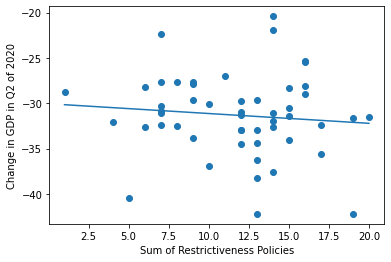

In [18]:
plt.scatter(relevantPolicies["restrictivenessMeasure"], relevantPolicies["Q2GDPChange"])
minRestric = min(relevantPolicies["restrictivenessMeasure"])
maxRestric = max(relevantPolicies["restrictivenessMeasure"])
xCords = np.linspace(minRestric, maxRestric)
yCords = xCords * relAggrRegr.coef_[0] + relAggrRegr.intercept_
plt.plot(xCords, yCords)
plt.xlabel("Sum of Restrictiveness Policies")
plt.ylabel("Change in GDP in Q2 of 2020")
plt.show()